In [1]:
from biodata.bed import BEDXReader, BED3Reader, BEDWriter
from biodata.gff import GFF3Reader
from genomictools import GenomicCollection
import aldentools.methods as pm
import aldentools.plot as ap
from biodata.delimited import DelimitedReader
import re
from collections import defaultdict
import urllib
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from biodatatools.utils.common import json_load
import seaborn as sns
from pathlib import Path
import os
from biodata.bed import BED, BEDWriter
from mphelper import ProcessWrapPool

In [2]:
font_dir = Path.cwd().parent / "font"
for font in ["Arial.ttf", "Arial_Bold.ttf"]:
    matplotlib.font_manager.fontManager.addfont(font_dir / font)
matplotlib.rcParams["font.family"] = "Arial"
bfontsize = 12
sfontsize = 9

In [3]:
PROJECT_DIR_d = "/home/yc2553/projects/HEA/databases/"
PROJECT_DIR_d2 = "/fs/cbsuhy02/storage/kl945/"
PROJECT_DIR_r = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/resources/genomes/human/"
PROJECT_DIR_o = "/home/yc2553/projects/HEA/output/"

# Data processing

In [4]:
ps = ["divergent", "unidirectional"]
ds = ["distal", "proximal"]
beds = json_load(f"{PROJECT_DIR_d}PROcap/metainfo/sample_beds.json")

In [ ]:
tss = BED3Reader.read_all(GenomicCollection, f'{PROJECT_DIR_r}gencode.v37.annotation.TSS.500.bed.bgz')
gffs = GFF3Reader.read_all(GenomicCollection, f'{PROJECT_DIR_r}gencode.v37.annotation.gff3.gz')
transcripts = pm.gencode_get_transcripts(gffs)

In [ ]:
df_map = pd.read_excel(f"{PROJECT_DIR_o}tables/SuppTable2.xlsx", sheet_name="Assay_comparison")
df_map.head(2)

## CAGE

In [ ]:
def fantom5_osc_extract_peaks(tpm_file, count_file, prefix, targets):
    dr_tpm = DelimitedReader(tpm_file)
    dr_count = DelimitedReader(count_file)
    beds = {target:BEDWriter(prefix + target.replace(" ", "-") + ".bed.gz") for target in targets}
    def resolve(d, prefix):
        col_dict = defaultdict(list)
        for a in range(1, len(d)):
            amended_name = urllib.parse.unquote(d[a]).split(prefix + ".")[1]
            if "fetal" in amended_name:
                continue
            if "newborn" in amended_name:
                continue
            if "treat" in amended_name:
                continue
            final_amended_name = amended_name.split(",")[0].split(" - adult")[0]
            if final_amended_name in targets:
                col_dict[final_amended_name].append(a)
        return dict(col_dict)
    d = dr_tpm.read()
    while d[0] != "00Annotation":
        d = dr_tpm.read()
    tpm_col_dict = resolve(d, "tpm")
    d = dr_tpm.read()
    while not d[0].startswith("02STAT"):
        d = dr_tpm.read()

    d = dr_count.read()
    while d[0] != "00Annotation":
        d = dr_count.read()
    count_col_dict = resolve(d, "counts")
    d = dr_count.read()
    while not d[0].startswith("01STAT"):
        d = dr_count.read()

    assert tpm_col_dict == count_col_dict
    col_dict = tpm_col_dict

    for d_tpm, d_count in zip(dr_tpm, dr_count):
        assert d_tpm[0] == d_count[0]
        name, start, stop, strand = re.match('(chr[^:]+):([0-9]+)..([0-9]+),([+-])', d_tpm[0]).groups()
        bed = BED(name, int(start), int(stop), strand=strand)

        for tissue, cols in col_dict.items():
            if any(float(d_tpm[col]) >= 1 and int(d_count[col]) >= 10 for col in cols):
                beds[tissue].write(bed)
    for bw in beds.values():
        bw.close()
    for dr in [dr_tpm, dr_count]:
        dr.close()

In [ ]:
df = df_map[["PRO-cap sample name", "PRO-cap sample ID", "CAGE sample name"]].dropna()
targets = sorted(df["CAGE sample name"])
len(targets)

In [15]:
fantom5_osc_extract_peaks(f"{PROJECT_DIR_d2}Resources/Fantom5/phase2.6/CAGE_peaks/hg19.cage_peak_phase1and2combined_tpm.osc.txt.gz",
                            f"{PROJECT_DIR_d2}Resources/Fantom5/phase2.6/CAGE_peaks/hg19.cage_peak_phase1and2combined_counts.osc.txt.gz",
                            f"{PROJECT_DIR_d2}HumanEnhancerAtlas/OtherDataset/20230515_fantom5_selected_CAGE_peaks/",
                            targets
                            )

## All assays

In [ ]:
mapping_files = defaultdict(dict)
assays = ["ATAC", "DNase", "H3K27ac", "cCRE", "CAGE"]
for assay in assays:
    pair = ("PROcap", assay)    
    if assay != "CAGE":
        df = df_map[["PRO-cap sample name", "PRO-cap sample ID", f"{assay} ENCODE ID"]].dropna()
    else:
        df = df_map[["PRO-cap sample name", "PRO-cap sample ID", "CAGE sample name"]].dropna()
    for _, row in df.iterrows():
        t = row["PRO-cap sample name"]
        mapping_files[pair][t] = defaultdict(dict)
        for p in ps:
            mapping_files[pair][t]["PROcap"][p] = [beds[s][ps.index(p)] for s in row["PRO-cap sample ID"].split(",")]
        
        if assay in ["ATAC", "DNase", "H3K27ac"]:
            mapping_files[pair][t][assay] = [f"{PROJECT_DIR_d2}Resources/ENCODE/files/{encid}.bed.gz" for encid in row[f"{assay} ENCODE ID"].split(",")]
        elif assay == "cCRE":
            mapping_files[pair][t][assay] = [f"{PROJECT_DIR_d2}Resources/ENCODE/cCREs/V4/CellTypes/{encid}.bed.gz" for encid in row[f"{assay} ENCODE ID"].split(",")]
        else:
            mapping_files[pair][t][assay] = f"{PROJECT_DIR_d2}HumanEnhancerAtlas/OtherDataset/20230515_fantom5_selected_CAGE_peaks/{'-'.join(row['CAGE sample name'].split(' '))}.bed.gz"

In [ ]:
for pair in mapping_files:
    print(pair, len(mapping_files[pair]))

In [ ]:
def read_cCRE_file(i, target_peaktypes):
    with BEDXReader(i, x=9, fieldnames=["peaktype", "classification"]) as br:
        return GenomicCollection([b.genomic_pos for b in br if b.peaktype in target_peaktypes])

In [ ]:
# Merge peaks from same tissue types
# CAGE: single file; liftover to hg38
# Note the definition of unidirectional here is different from the union set

def process_peaks(mapping_files, assay):
    if assay == "PROcap":
        processed_peaks = {}
        for p in ps:
            processed_peaks[p] = pm.merge_overlapped_regions(*[BED3Reader.read_all(GenomicCollection, f) for f in mapping_files[p]])
    elif assay == "CAGE":
        processed_peaks = pm.liftOver_and_get_successful_candidates(BED3Reader.read_all(GenomicCollection, mapping_files), f"{PROJECT_DIR_r}hg19ToHg38.over.chain.gz")
    elif assay == "cCRE":
        processed_peaks = pm.merge_overlapped_regions(*[read_cCRE_file(f, ["dELS", "pELS", "PLS"]) for f in mapping_files])
    else:
        processed_peaks = pm.merge_overlapped_regions(*[BED3Reader.read_all(GenomicCollection, f) for f in mapping_files])
    
    return processed_peaks

In [ ]:
pwpool = ProcessWrapPool(10)

map_dict = {}
for pair in mapping_files:
	for t in mapping_files[pair]:
		for assay in mapping_files[pair][t]:
			map_dict[(pair, t, assay)] = pwpool.run(process_peaks, args=[mapping_files[pair][t][assay], assay])

In [15]:
len(pwpool.finished_tasks)

368

In [16]:
temp = pwpool.get()

In [17]:
processed_peaks = {}
for pair, t, assay in map_dict:
    if pair not in processed_peaks:
        processed_peaks[pair] = defaultdict(dict)
    if assay == "PROcap":
        for p in ps:
            processed_peaks[pair][(assay,p)][t] = temp[map_dict[(pair, t, assay)]][p]
    else:
        processed_peaks[pair][assay][t] = temp[map_dict[(pair, t, assay)]]

In [18]:
# pwpool.close()

# Comparison between assays

In [19]:
data = {}
expansion_size = 1000
for pair in processed_peaks:
	other_assay = pair[1]
	procap_div_dict = {t:pm._expand_genomic_collection_20210316(procap, expansion_size) for t, procap in processed_peaks[pair][("PROcap","divergent")].items()}
	procap_uni_dict = {t:pm._expand_genomic_collection_20210316(procap, expansion_size) for t, procap in processed_peaks[pair][("PROcap","unidirectional")].items()}
	other_dict = {t:pm._expand_genomic_collection_20210316(other, expansion_size) for t, other in processed_peaks[pair][other_assay].items()}
	data[other_assay] = (procap_div_dict, procap_uni_dict, other_dict)

## PRO-cap anchored

In [21]:
def create_overlap_ratio_expanded(data, tss, transcripts):
	overlap_percent_dict = defaultdict(lambda: defaultdict(list))
	for other_assay, (procap_div_dict, procap_uni_dict, other_dict) in data.items():
		for peak_type, procap_dict in zip(["divergent", "unidirectional"], [procap_div_dict, procap_uni_dict]):
			for t, procap in procap_dict.items():
				other = other_dict[t]
				proximal = [r for r in procap if tss.overlaps(r)]
				distal_intragenic = [r for r in procap if not tss.overlaps(r) and transcripts.overlaps(r)]
				distal_intergenic = [r for r in procap if not tss.overlaps(r) and not transcripts.overlaps(r)]
				
				overlap_percent_dict[f"Proximal {peak_type}"][other_assay].append(sum(other.overlaps(r) for r in proximal) / len(proximal))
				overlap_percent_dict[f"Distal {peak_type} (intragenic)"][other_assay].append(sum(other.overlaps(r) for r in distal_intragenic) / len(distal_intragenic))
				overlap_percent_dict[f"Distal {peak_type} (intergenic)"][other_assay].append(sum(other.overlaps(r) for r in distal_intergenic) / len(distal_intergenic))                
				
	return overlap_percent_dict

In [22]:
procap_ratios = create_overlap_ratio_expanded(data, tss, transcripts)

In [23]:
def get_ratio_df(ratios):
	results = []
	for category in ratios:
	    for other_assay in ratios[category]:
	        for ratio in ratios[category][other_assay]:
	            results.append([category, other_assay, ratio])
	df_ratio = pd.DataFrame(results, columns=["Category", "Assay", "Ratio"])
	return df_ratio

In [24]:
df_procap_ratios = get_ratio_df(procap_ratios)

In [25]:
order = []
for p in ps:
    order.extend([f"Distal {p} (intergenic)", f"Distal {p} (intragenic)", f"Proximal {p}"])
palette = ["#d7191c", "#fdae61", "#e78ac3", "#2b83ba", "#abdda4"]

In [26]:
def plot_ratios(df, order, figsize, outputfile):
    fig, ax = plt.subplots(figsize=figsize)
    g = sns.violinplot(data=df, x="Category", y="Ratio", order=order, fill=False,
                       hue="Assay", hue_order=assays, palette=palette, 
                       inner_kws={"box_width":3}, density_norm="width", gap=0.1,
                       cut=0, ax=ax
                      )
    g.legend(loc="upper center", bbox_to_anchor=(0.5,1.3), ncols=len(assays), fontsize=sfontsize, frameon=False)
    g.spines[["top", "right"]].set_visible(False)
    g.set_xlabel("")
    g.set_ylabel("Overlap fraction", fontsize=bfontsize)
    g.tick_params(axis="x", labelsize=bfontsize, rotation=30)
    for label in g.get_xticklabels():
        label.set_horizontalalignment("right")
    g.tick_params(axis="y", labelsize=sfontsize)
    plt.savefig(outputfile, bbox_inches="tight", transparent=True)

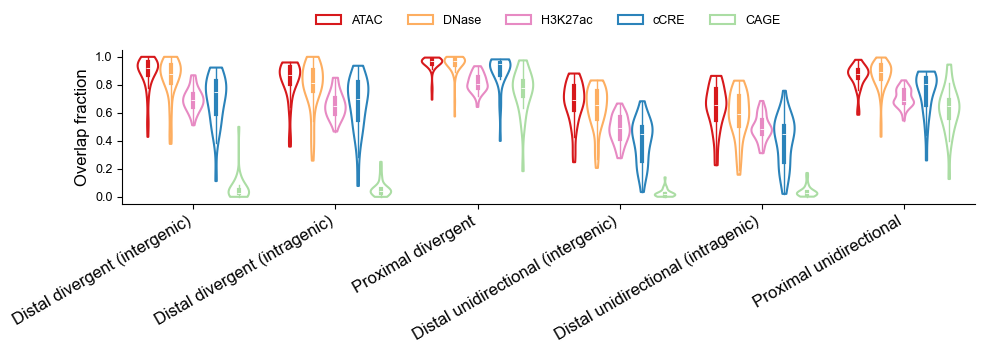

In [27]:
outputfile = f"{PROJECT_DIR_o}figures/ExtDataFig1a.pdf"
plot_ratios(df_procap_ratios, order, (11,2), outputfile)

## Other assay anchored

In [28]:
def create_rev_overlap_ratio_expanded(data, tss, transcripts):
    overlap_percent_dict = defaultdict(lambda: defaultdict(list))
    for other_assay, (procap_div_dict, procap_uni_dict, other_dict) in data.items():
        for t in other_dict:
            other = other_dict[t]
            proximal = [r for r in other if tss.overlaps(r)]
            distal_intragenic = [r for r in other if not tss.overlaps(r) and transcripts.overlaps(r)]
            distal_intergenic = [r for r in other if not tss.overlaps(r) and not transcripts.overlaps(r)]
            procap_div = procap_div_dict[t]
            procap_uni = procap_uni_dict[t]

            overlap_percent_dict["Proximal"][other_assay].append(sum(procap_uni.overlaps(r) or procap_div.overlaps(r) for r in proximal) / len(proximal))
            overlap_percent_dict["Distal (intragenic)"][other_assay].append(sum(procap_uni.overlaps(r) or procap_div.overlaps(r) for r in distal_intragenic) / len(distal_intragenic))
            overlap_percent_dict["Distal (intergenic)"][other_assay].append(sum(procap_uni.overlaps(r) or procap_div.overlaps(r) for r in distal_intergenic) / len(distal_intergenic))
                
    return overlap_percent_dict

In [29]:
other_ratios = create_rev_overlap_ratio_expanded(data, tss, transcripts)

In [30]:
df_other_ratios = get_ratio_df(other_ratios)

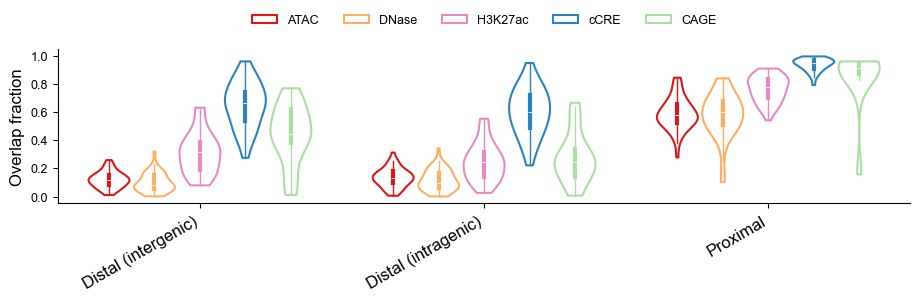

In [31]:
order2 = ["Distal (intergenic)", "Distal (intragenic)", "Proximal"]
outputfile = f"{PROJECT_DIR_o}figures/ExtDataFig1b.pdf"
plot_ratios(df_other_ratios, order2, (11,2), outputfile)